### Команда "Страховщики":

- Мартынов Дмитрий
- Осипов Роман
- Иванков Дмитрий
- Плахотин Андрей
- Максим Макаров
- Тайсумова Луиза

# Кейс 10 - Бинарная классификация перекрёстных продаж страхования

- [1. Общая информация о данных](#first)
- [2. Анализ целевой переменной](#second)
- [3. Анализ категориальных признаков](#third)
  - [3.1 Бинарные признаки](#third-one)
  - [3.2 Порядковые признаки](#third-two)
  - [3.3 Высококардинальные категориальные признаки](#third-three)
- [4. Анализ числовых признаков](#fource)
- [5. Корреляционный анализ по числовым признакам](#fifth)
- [6. Итоги EDA и рекомендации](#sixth)
- [7. Baseline - логистическая регрессия](#seventh)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [2]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

<a id="first"></a>
## 1. Общая информация о данных

* id - порядковый номер
* Gender - пол
* Age - возраст
* Driving_License - наличие ВУ
* Region_Code - код региона
* Previously_Insured - застраховано ли ранее ТС
* Vehicle_Age - возраст ТС
* Vehicle_Damage - происходили ли ранее ДТП
* Annual_Premium - страховая премия
* Policy_Sales_Channel - идентификатор продавца
* Vintage - количество дней страхования в компании
* Response - ответил ли страхователь на предложение


In [3]:
df = pd.read_csv(FILE_PATH, index_col='id')

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.00,0,1-2 Year,Yes,"65,101.00",124.00,187,0
1,Male,43,1,28.00,0,> 2 Years,Yes,"58,911.00",26.00,288,1
2,Female,25,1,14.00,1,< 1 Year,No,"38,043.00",152.00,254,0
3,Female,35,1,1.00,0,1-2 Year,Yes,"2,630.00",156.00,76,0
4,Female,36,1,15.00,1,1-2 Year,No,"31,951.00",152.00,294,0


In [4]:
df.shape

(11504798, 11)

**Вывод:**
- 11 504 798 - строк
- 11 - столбцов

In [5]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   Gender                11504798 non-null  object 
 1   Age                   11504798 non-null  int64  
 2   Driving_License       11504798 non-null  int64  
 3   Region_Code           11504798 non-null  float64
 4   Previously_Insured    11504798 non-null  int64  
 5   Vehicle_Age           11504798 non-null  object 
 6   Vehicle_Damage        11504798 non-null  object 
 7   Annual_Premium        11504798 non-null  float64
 8   Policy_Sales_Channel  11504798 non-null  float64
 9   Vintage               11504798 non-null  int64  
 10  Response              11504798 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [6]:
df.isnull().sum() # проверка пропусков

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
df.duplicated().sum() # проверка на дубликаты

np.int64(0)

**Вывод:**
- 3 object
- 5 int64
- 3 float64
- Пропуски отсутствуют
- Дубликаты отсутствуют

### Разделение на категории

In [8]:
num_columns    = ["Age", "Annual_Premium", "Vintage"] # числовые
cat_colums     = ["Region_Code", "Vehicle_Age", "Policy_Sales_Channel"] # категориальные
binary_columns = ["Gender", "Driving_License", "Previously_Insured", "Vehicle_Damage", "Response"] # категориальные-бинарные

**Вывод:**

- 3 числовых
- 8 категориальных

<a id="second"></a>
## 2. Анализ целевой переменной

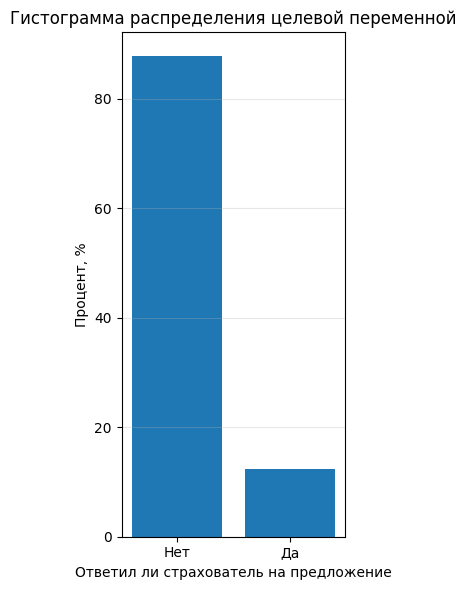

In [9]:
response_counts = df['Response'].value_counts().sort_index()
total_count = len(df)
percentages = (response_counts / total_count) * 100
plt.figure(figsize=(3, 6))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Гистограмма распределения целевой переменной')
plt.xlabel('Ответил ли страхователь на предложение')
plt.ylabel('Процент, %')
plt.xticks(percentages.index, ['Нет', 'Да'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**

Сильный дисбаланс классов: 85% клиентов отвечают «Нет», 15% — «Да».
Это может привести к смещению модели в сторону "Нет", если не использовать правильные метрики и методы балансировки.
Модель должна быть обучена не на точности (accuracy), а на способности находить редкие положительные случаи.

<a id="third"></a>
## 3. Анализ категориальных признаков

<a id="third-one"></a>
### 3.1 Бинарные признаки "Gender", "Driving_License", "Previously_Insured", "Vehicle_Damage"

In [10]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

# переводим Dtype бинарных признаков в category
for col in binary_columns:
    df[col] = df[col].astype('category')

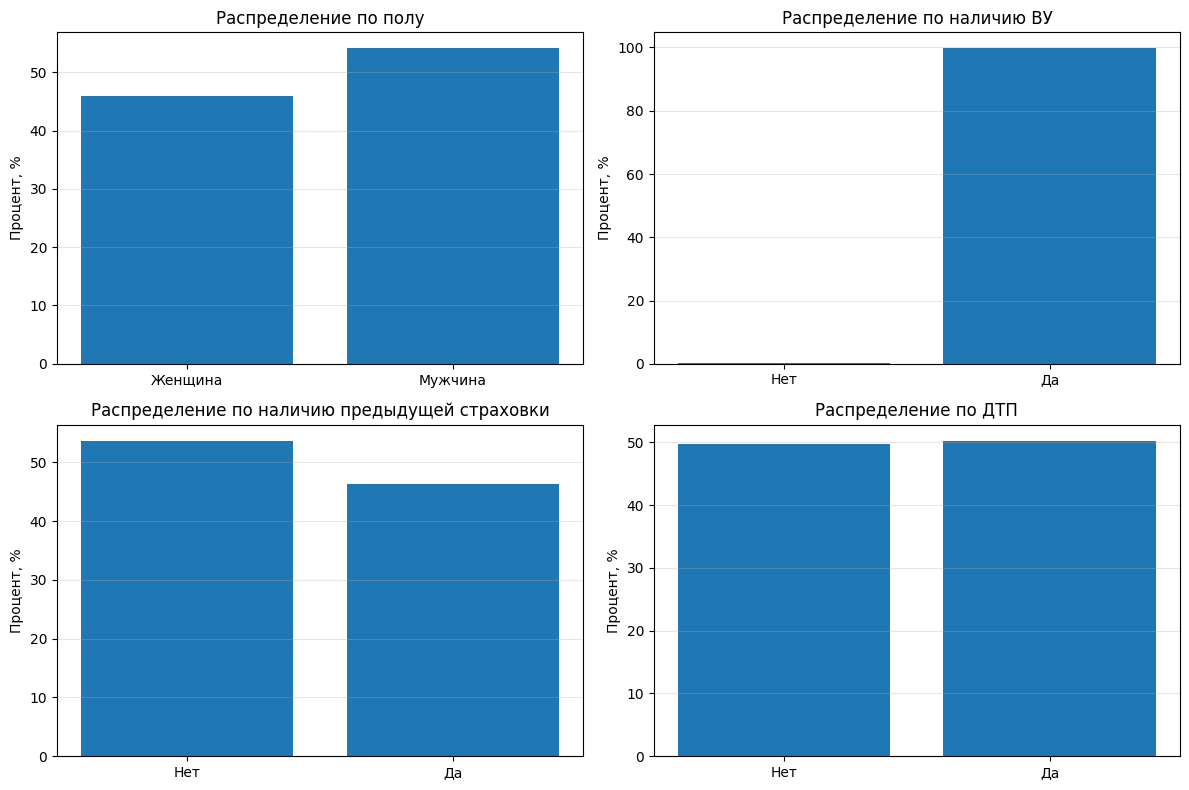

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

response_counts = df['Gender'].value_counts().sort_index()
response_percentages = (response_counts / len(df)) * 100
ax1.bar(['Женщина', 'Мужчина'], response_percentages.values)
ax1.set_title('Распределение по полу')
ax1.set_ylabel('Процент, %')
ax1.grid(axis='y', alpha=0.3)

dl_counts = df['Driving_License'].value_counts().sort_index()
dl_percentages = (dl_counts / len(df)) * 100
ax2.bar(['Нет', 'Да'], dl_percentages.values)
ax2.set_title('Распределение по наличию ВУ')
ax2.set_ylabel('Процент, %')
ax2.grid(axis='y', alpha=0.3)

pi_counts = df['Previously_Insured'].value_counts().sort_index()
pi_percentages = (pi_counts / len(df)) * 100
ax3.bar(['Нет', 'Да'], pi_percentages.values)
ax3.set_title('Распределение по наличию предыдущей страховки')
ax3.set_ylabel('Процент, %')
ax3.grid(axis='y', alpha=0.3)

vd_counts = df['Vehicle_Damage'].value_counts().sort_index()
vd_percentages = (vd_counts / len(df)) * 100
ax4.bar(['Нет', 'Да'], vd_percentages.values)
ax4.set_title('Распределение по ДТП')
ax4.set_ylabel('Процент, %')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод:**

- Мужчины чаше берут страховку - значимый признак
- Большая часть страхователей имеют ВУ - малополезен для модели, можно удалить
- Больше половины клиентов не имели предыдущей страховки - новые клиенты основная целевая аудитория
- Участие в ДТП в соотношении 50/50 - если были ДТП — выше вероятность покупки

Можно предположить, что мужчины с водительским удостоверением, впервые страхующиеся и участвовавшие в ДТП, с большей долей вероятности возьмут доп. страховку

<a id="third-two"></a>
### 3.2 Порядковый признак "Vehicle_Age"

In [12]:
vehicle_age_unique = df['Vehicle_Age'].unique()
print(vehicle_age_unique)

['1-2 Year' '> 2 Years' '< 1 Year']


In [13]:
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('category')

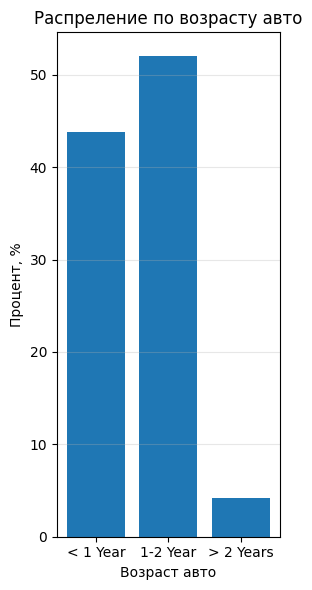

In [14]:
response_counts = df['Vehicle_Age'].value_counts().sort_index()
total_count = len(df)
percentages = (response_counts / total_count) * 100
plt.figure(figsize=(3, 6))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Распреление по возрасту авто')
plt.xlabel('Возраст авто')
plt.ylabel('Процент, %')
plt.xticks(percentages.index, ['< 1 Year', '1-2 Year', '> 2 Years'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
- Чаще страхуют новые авто не старше 2-х лет

<a id="third-three"></a>
### 3.3 Высококардинальные признаки "Region_Code", "Policy_Sales_Channel"

In [15]:
region_code_unique = df['Region_Code'].unique()
print(region_code_unique)

[35.  28.  14.   1.  15.  47.  45.   8.  11.   3.  10.  12.  37.  50.
 30.  46.  29.  16.  26.  25.  41.  48.   7.   4.  24.  36.  33.   2.
  9.  27.  18.  43.  49.  17.  13.  38.   6.  21.  23.   0.  19.   5.
 39.  44.  20.  40.  22.  32.  42.  31.  34.  51.  52.  39.2]


Проверяем аномальное значение '39.2' на сколько часто встречается

In [16]:
print(df[df['Region_Code'] == 39.2].shape[0])

1


Так как значение '39.2' встречается только 1 раз, удаляем строку с ним из датасета:

In [17]:
df = df[df['Region_Code'] != 39.2]

Построим частотную гистограмму для визуализации признака "Region_Code"

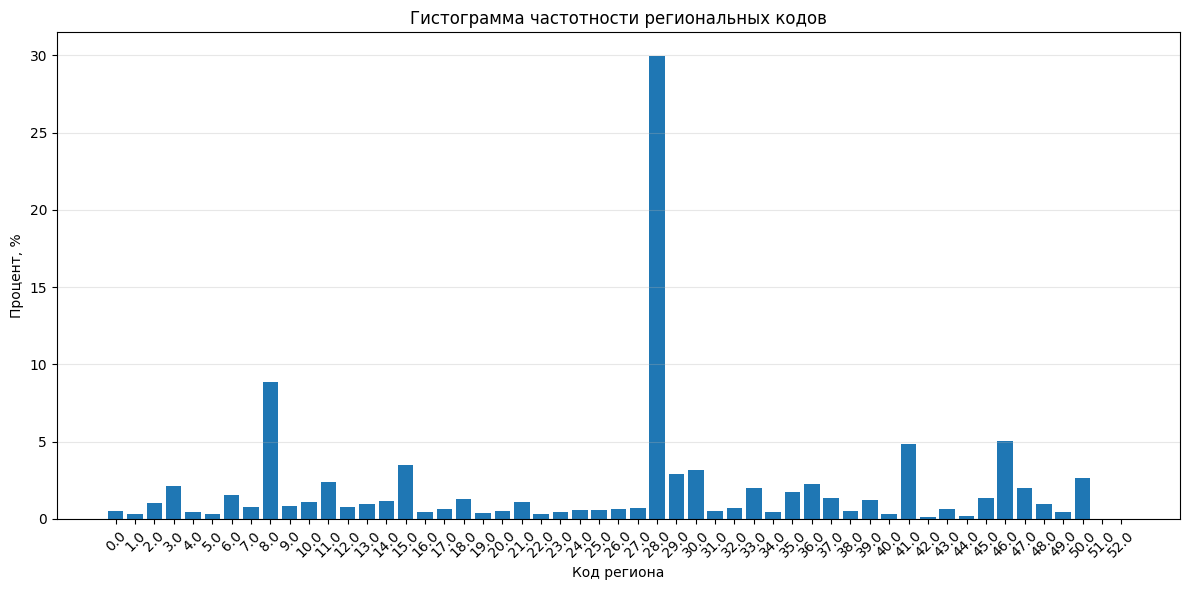

In [18]:
region_counts = df['Region_Code'].value_counts().sort_index()
total_count = len(df)
percentages = (region_counts / total_count) * 100
plt.figure(figsize=(12, 6))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Гистограмма частотности региональных кодов')
plt.xlabel('Код региона')
plt.ylabel('Процент, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Выполним Frequency Encoding (частотное кодирование) для "Region_Code", чтобы заменить этот столбец на процентное представление частоты каждого региона:

In [19]:
region_percentages = (df['Region_Code'].value_counts() / len(df)) * 100
df['Region_Code_Percentage'] = df['Region_Code'].map(region_percentages)
df.drop('Region_Code', axis=1, inplace=True)

**Выводы по применению частотного кодирования:**
- "Region_Code" - это категории без порядка, следоваетльно, мы избегаем ложного порядка
- Снижение размерности
- Сохрание информации: регионы, где много клиентов, получают большие значения
- Безопасно с точки зрения утечки, не использует целевую переменную

In [20]:
policy_sales_channel_unique = df['Policy_Sales_Channel'].unique()
print(policy_sales_channel_unique)
print(f"Количество уникальных продавцов: {len(policy_sales_channel_unique)}")

[124.  26. 152. 156. 160.   8.  31. 157.  60. 122.  15.  30. 147.   1.
  63. 136. 154.  18. 135. 151.   3.  10.  55. 108.   7.  29. 163.  13.
 133. 145.  25.  12. 109.  23.  78.   4. 153. 150. 146. 120. 107. 155.
  61.  14.  45.  11.  19.  24.  52. 132. 125.  59.  16.  22.  56.  20.
 148. 158. 159. 139.   9. 113. 121.  21. 111.  64. 116. 103. 128.  65.
  37.  91. 129. 127. 106. 140.  35. 131.  17.  93.  90.  36. 118.  54.
  62. 138.  42.  46.  86.  80.  68. 119.  94.  48.  47.  83.  97.  70.
  53.  44. 114.  98.  88. 110.  32. 126.  96.  99. 130.  66. 105.  51.
  38. 137.  89.  81.  92. 117.  73.  69.  49.  87.  33.  39.  50. 123.
  75. 101. 115. 100.  95.  57.  71. 134.  82.   6.  58. 104.  41.  40.
   2.  79.  34.  76.  28.  74.  43.  67.  27. 112. 102.   5.]
Количество уникальных продавцов: 152


Построим частотную гистограмму для визуализации признака "Policy_Sales_Channel"

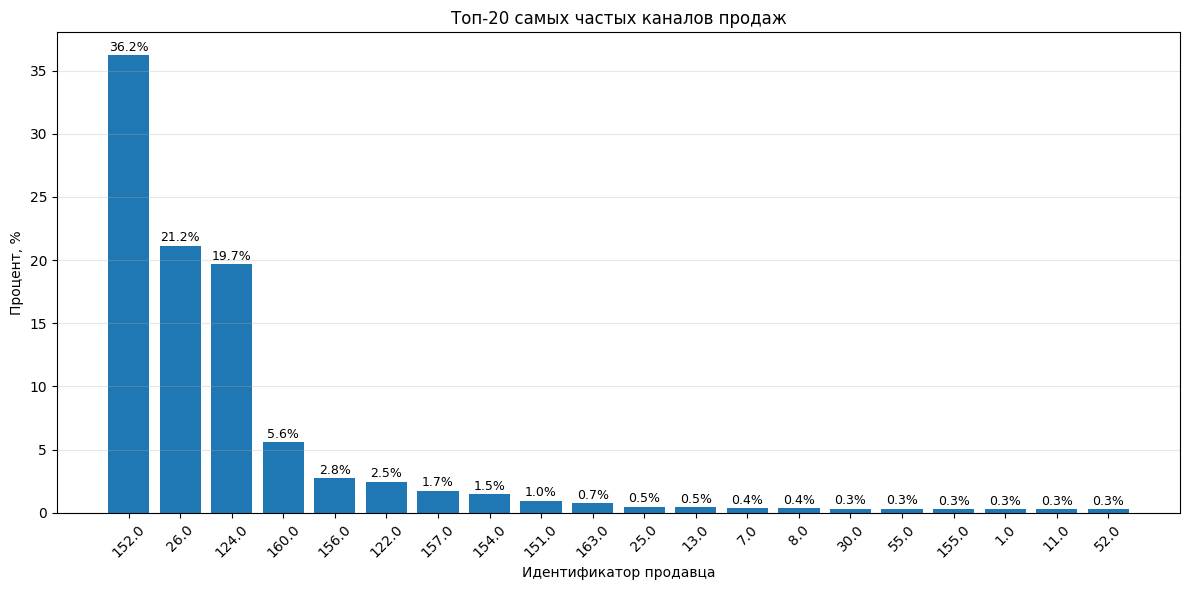

In [21]:
top_n = 20
channel_counts = df['Policy_Sales_Channel'].value_counts().head(top_n)
total_count = len(df)
percentages = (channel_counts / total_count) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(percentages.index.astype(str), percentages.values)
plt.title(f'Топ-{top_n} самых частых каналов продаж')
plt.xlabel('Идентификатор продавца')
plt.ylabel('Процент, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar, percentage in zip(bars, percentages.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Реализуем Frequency Encoding (частотное кодирование) с предварительной группировкой редких категорий для признака "Policy_Sales_Channel":

Всего уникальных продавцов: 152
Продавцов с частотностью >1%: 8


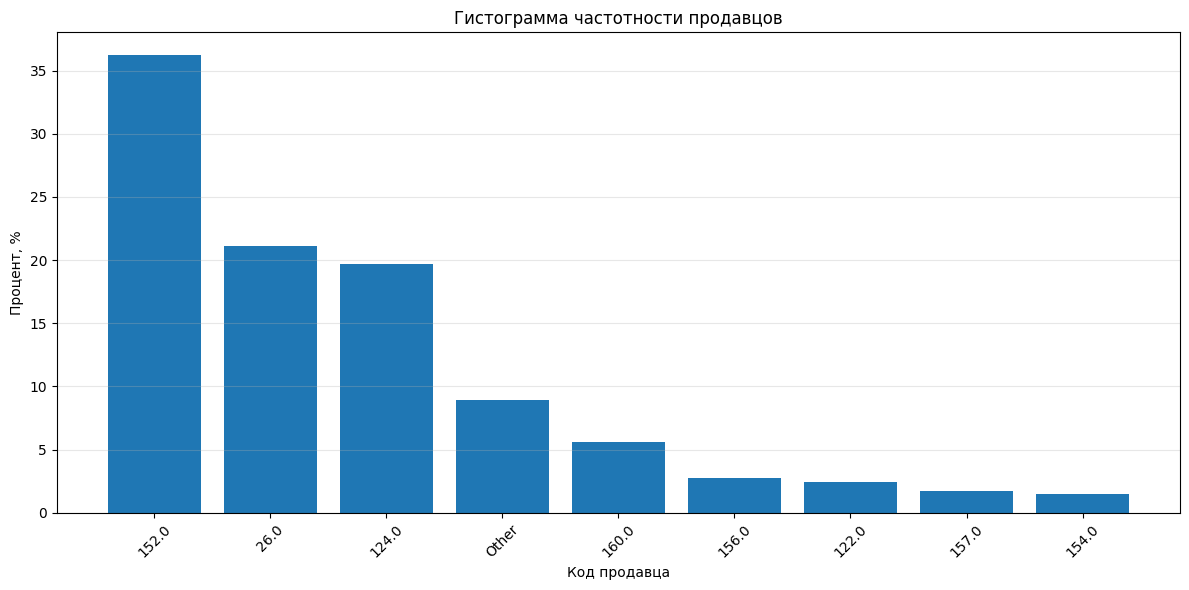

In [22]:
channel_counts = df['Policy_Sales_Channel'].value_counts(normalize=True) * 100
print(f"Всего уникальных продавцов: {len(channel_counts)}")

top_channels = channel_counts[channel_counts > 1].index
print(f"Продавцов с частотностью >1%: {len(top_channels)}")

df['Policy_Sales_Channel_Grouped'] = df['Policy_Sales_Channel'].apply(
    lambda x: x if x in top_channels else 'Other'
)

grouped_freq = df['Policy_Sales_Channel_Grouped'].value_counts(normalize=True)
channel_percentages = grouped_freq * 100

df['Policy_Sales_Channel_Percentage'] = df['Policy_Sales_Channel_Grouped'].map(channel_percentages)

plt.figure(figsize=(12, 6))
plt.bar(channel_percentages.index.astype(str), channel_percentages.values)
plt.title('Гистограмма частотности продавцов')
plt.xlabel('Код продавца')
plt.ylabel('Процент, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

df.drop('Policy_Sales_Channel', axis=1, inplace=True)
df.drop('Policy_Sales_Channel_Grouped', axis=1, inplace=True)


**Вывод:**
- Основная масса клиентов приходит через 3 ключевых канала: 152, 26, 124
- Группа "Other" - значимая, но не доминирующая
- Можно работать с ограниченным числом каналов, а остальные объединять

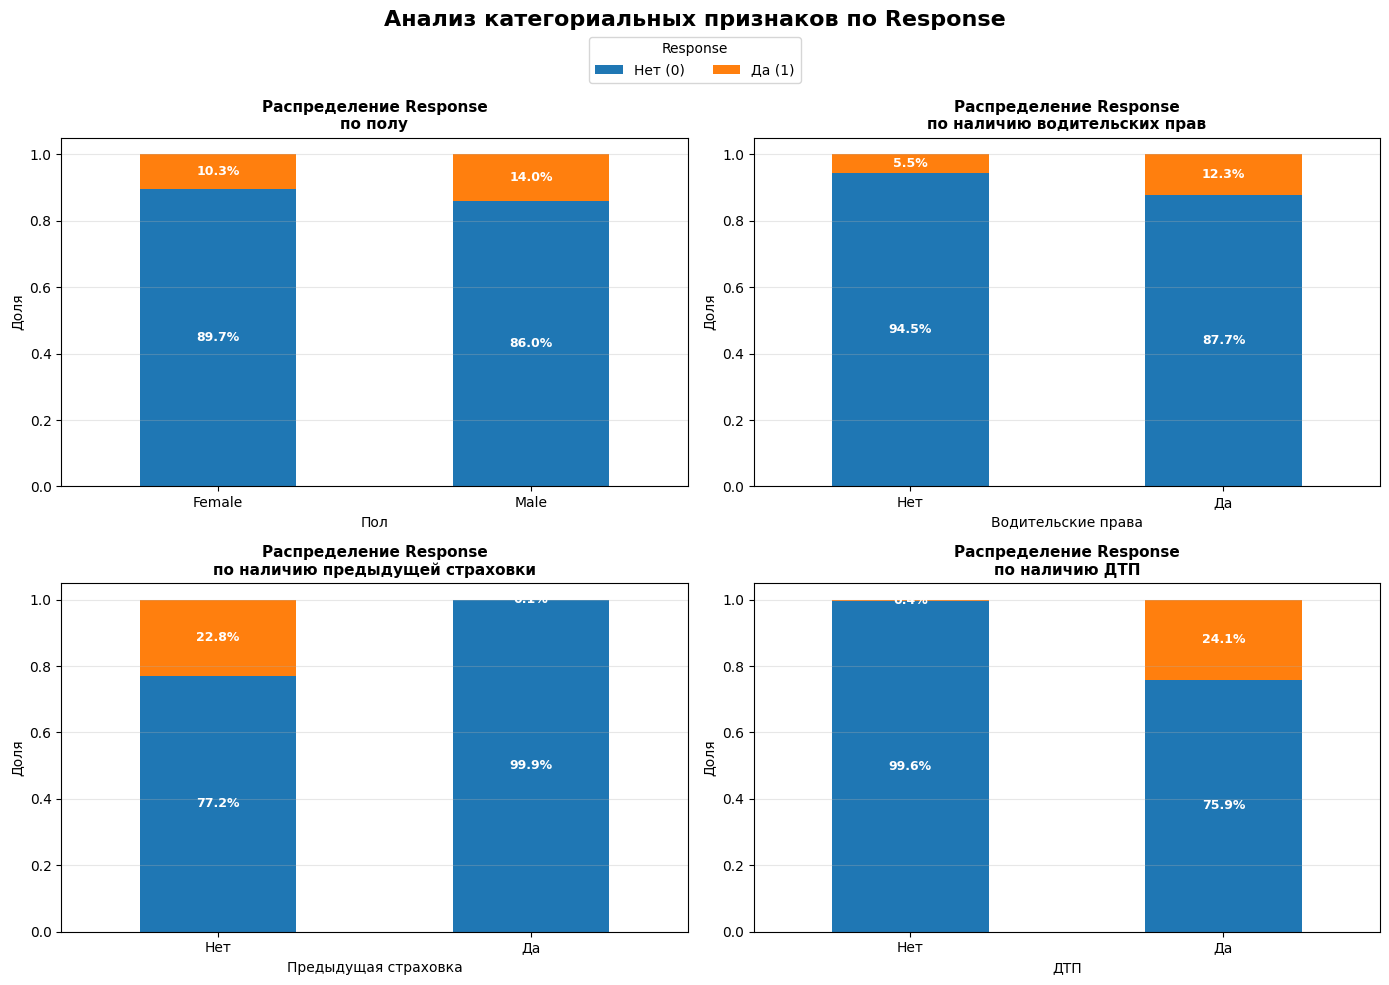

In [23]:
def plot_response_by_category(ax, category, title, xlabel):
    ct = pd.crosstab(category, df['Response'], normalize='index')

    bars = ct.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=['#1f77b4', '#ff7f0e'],
        legend=False
    )

    for container in bars.containers:
        bars.bar_label(
            container,
            labels=[f'{v:.1%}' for v in container.datavalues],
            label_type='center',
            fontsize=9,
            color='white',
            weight='bold'
        )

    ax.set_title(f'Распределение Response\nпо {title}', fontsize=11, weight='bold')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Доля', fontsize=10)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Анализ категориальных признаков по Response', fontsize=16, weight='bold')

axes = axes.flatten()

categories = [
    df['Gender'].map({0: 'Female', 1: 'Male'}),
    df['Driving_License'].map({0: 'Нет', 1: 'Да'}),
    df['Previously_Insured'].map({0: 'Нет', 1: 'Да'}),
    df['Vehicle_Damage'].map({0: 'Нет', 1: 'Да'})
]

titles = [
    'полу',
    'наличию водительских прав',
    'наличию предыдущей страховки',
    'наличию ДТП'
]

xlabels = ['Пол', 'Водительские права', 'Предыдущая страховка', 'ДТП']

for i in range(4):
    plot_response_by_category(axes[i], categories[i], titles[i], xlabels[i])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Нет (0)', 'Да (1)'], title='Response', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**Вывод:**

1. Мужчины чаще берут доп страховку, нежели женщины
2. Люди с ВУ чаще берут доп страховку, нежели без ВУ
3. Люди, без предыдущей страховки, чаще берут доп страховку. Те, кто продлевает, практически никогда не берут доп страховку
4. Люди, ранее попадавшие в ДТП, чаще берут страховку. Те, кто не попадал в ДТП,  практически никогда не берут доп страховку

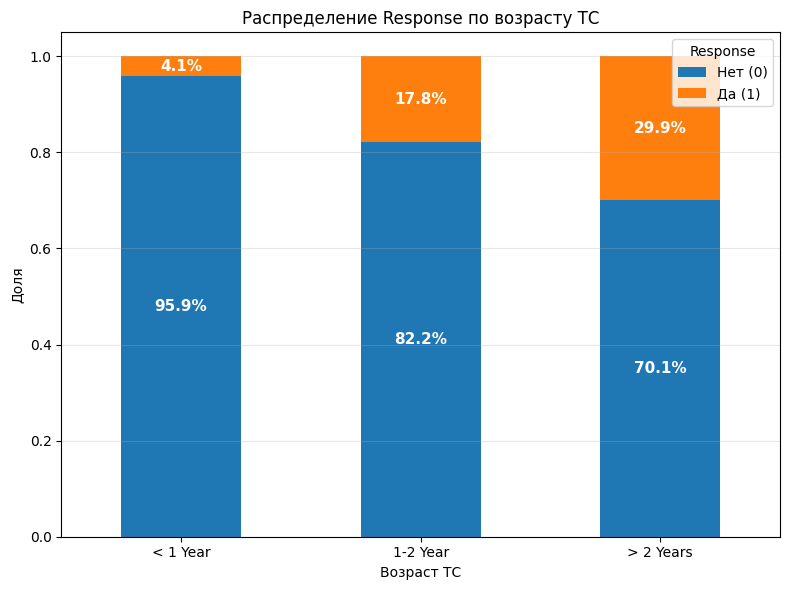

In [24]:
ct = pd.crosstab(df['Vehicle_Age'].map({0: '< 1 Year', 1: '1-2 Year', 2: '> 2 Years'}), df['Response'], normalize='index')

ax = ct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])

for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{v:.1%}' for v in container.datavalues],
                 label_type='center', fontsize=11, color='white', weight='bold')

plt.title('Распределение Response по возрасту ТС')
plt.xlabel('Возраст ТС')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.legend(title='Response', labels=['Нет (0)', 'Да (1)'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
- чем старше авто, тем выше вероятность, что человек возьмет доп страховку

Для определения распределения "Response" по "Region_Code_Percentage" и по "Policy_Sales_Channel_Percentage" необходимо агрегировать данные: для каждого значения "Region_Code_Percentage" и "Policy_Sales_Channel_Percentage" посчитать среднее значение "Response"

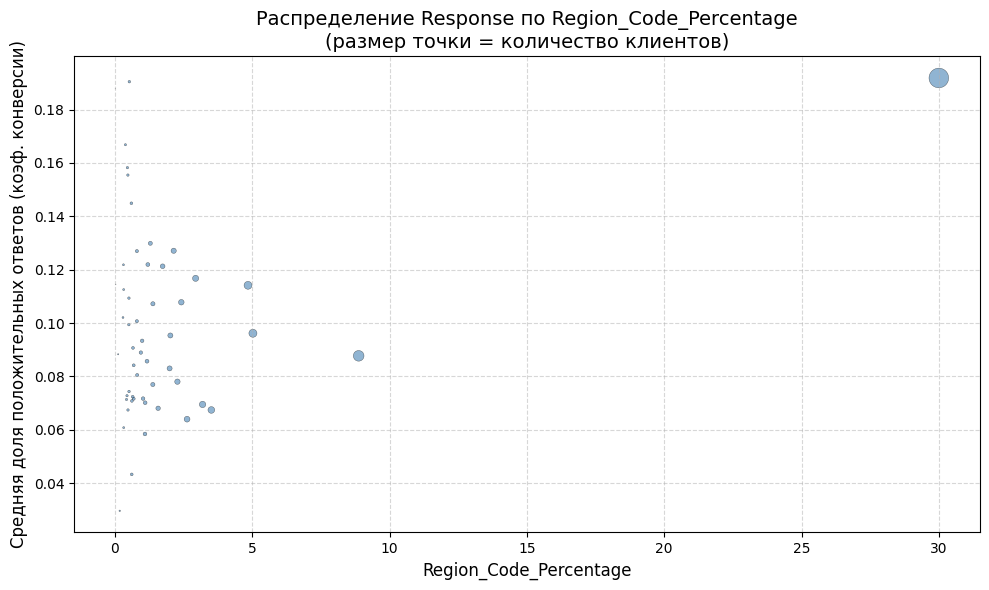

In [25]:
df['Response'] = pd.to_numeric(df['Response'])
df['Region_Code_Percentage'] = pd.to_numeric(df['Region_Code_Percentage'])

agg_df = df.groupby('Region_Code_Percentage')['Response'].agg(['mean', 'size']).reset_index()
agg_df = agg_df.sort_values('Region_Code_Percentage')

sizes = agg_df['size'] / agg_df['size'].max() * 200

plt.figure(figsize=(10, 6))
plt.scatter(
    agg_df['Region_Code_Percentage'],
    agg_df['mean'],
    s=sizes,
    color='steelblue',
    alpha=0.6,
    edgecolor='k',
    linewidth=0.3
)

plt.xlabel('Region_Code_Percentage', fontsize=12)
plt.ylabel('Средняя доля положительных ответов (коэф. конверсии)', fontsize=12)
plt.title('Распределение Response по Region_Code_Percentage\n(размер точки = количество клиентов)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
- Популярность региона коррелирует с конверсией - чем больше клиентов в регионе, тем выше вероятность, что они купят допуслугу

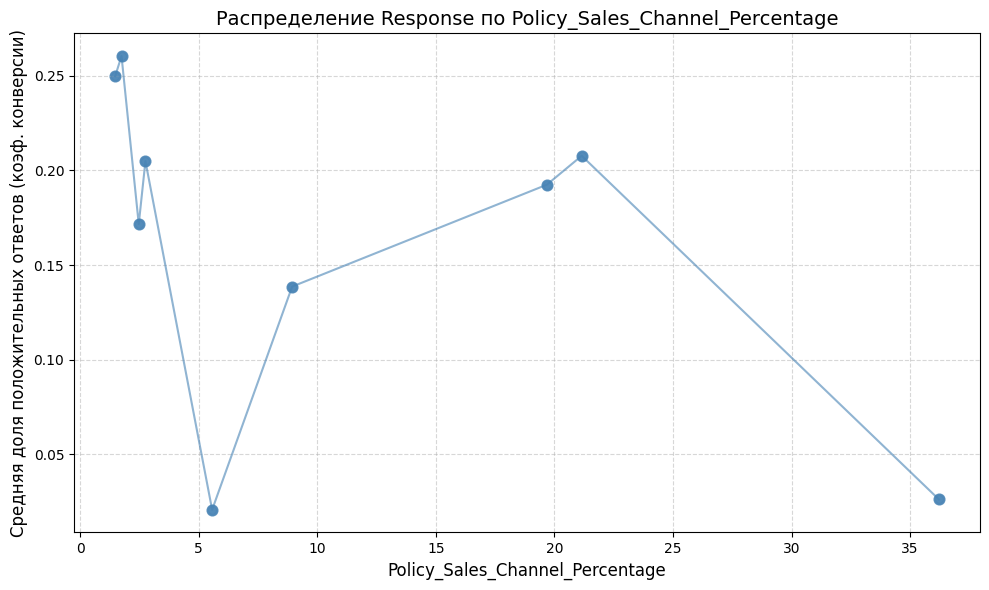

In [26]:
df['Response'] = pd.to_numeric(df['Response'])
df['Policy_Sales_Channel_Percentage'] = pd.to_numeric(df['Policy_Sales_Channel_Percentage'])

# Агрегация: среднее значение Response по каждому уникальному Policy_Sales_Channel_Percentage
agg_df = df.groupby('Policy_Sales_Channel_Percentage')['Response'].mean().reset_index()
agg_df = agg_df.sort_values('Policy_Sales_Channel_Percentage')

plt.figure(figsize=(10, 6))
plt.scatter(agg_df['Policy_Sales_Channel_Percentage'], agg_df['Response'], color='steelblue', s=60, alpha=0.8)
plt.plot(agg_df['Policy_Sales_Channel_Percentage'], agg_df['Response'], color='steelblue', linestyle='-', marker='o', alpha=0.6)

plt.xlabel('Policy_Sales_Channel_Percentage', fontsize=12)
plt.ylabel('Средняя доля положительных ответов (коэф. конверсии)', fontsize=12)
plt.title('Распределение Response по Policy_Sales_Channel_Percentage', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
- Конверсия по каналам продаж нелинейно зависит от их популярности - не самые массовые, а нишевые или средние каналы работают лучше всего

<a id="fource"></a>
## Анализ числовых признаков "Age", "Annual_Premium", "Vintage"

In [27]:
df[['Age', 'Annual_Premium', 'Vintage']].describe().drop('count').round(0)

,Age,Annual_Premium,Vintage
mean,38.00,"30,461.00",164.00
std,15.00,"16,455.00",80.00
min,20.00,"2,630.00",10.00
25%,24.00,"25,277.00",99.00
50%,36.00,"31,824.00",166.00
75%,49.00,"39,451.00",232.00
max,85.00,"540,165.00",299.00


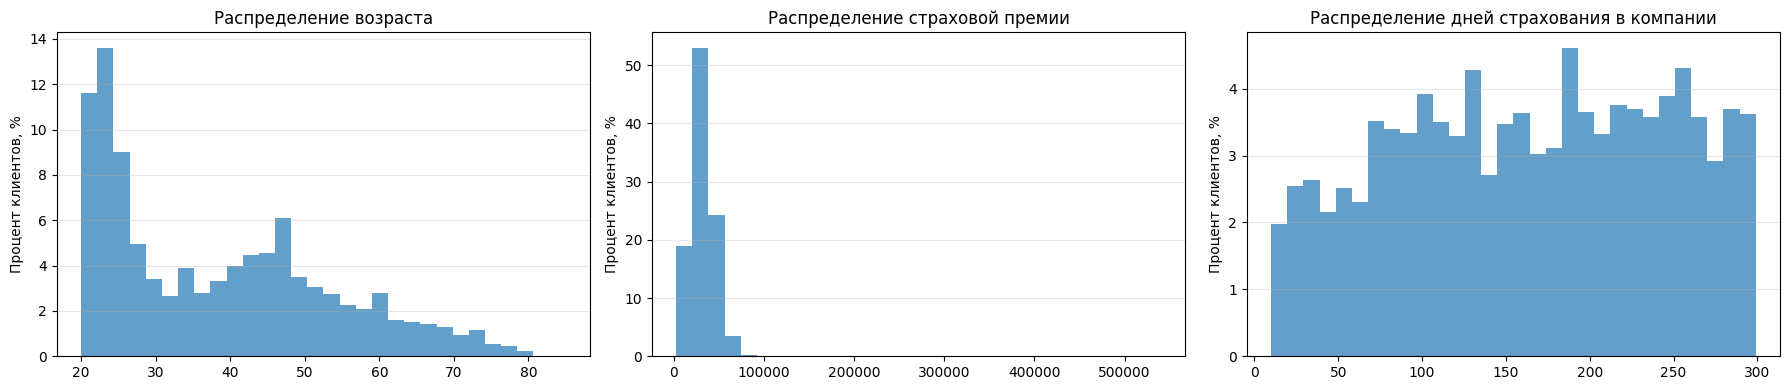

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

def plot_true_percentage_hist(data, ax, title, bins=30):
    counts, bins, patches = ax.hist(data, bins=bins, alpha=0.7, weights=np.ones(len(data)) / len(data) * 100)
    ax.set_title(title)
    ax.set_ylabel('Процент клиентов, %')
    ax.grid(axis='y', alpha=0.3)
    return counts, bins, patches

# Возраст
counts1, bins1, patches1 = plot_true_percentage_hist(df['Age'], ax1, 'Распределение возраста')

# Годовая премия
counts2, bins2, patches2 = plot_true_percentage_hist(df['Annual_Premium'], ax2, 'Распределение страховой премии')

# Vintage
counts3, bins3, patches3 = plot_true_percentage_hist(df['Vintage'], ax3, 'Распределение дней страхования в компании')

plt.tight_layout()
plt.show()

**Вывод:**

1. Основной возраст страхования: 20-30, 40-50
2. Нелинейная связь, есть выбросы
3. Клиенты равномерно распределены по времени, но с небольшим пиком в районе 200 дней

Для наглядности распределения "Annual_Premium" используем скрипичный график с логарифмированием:

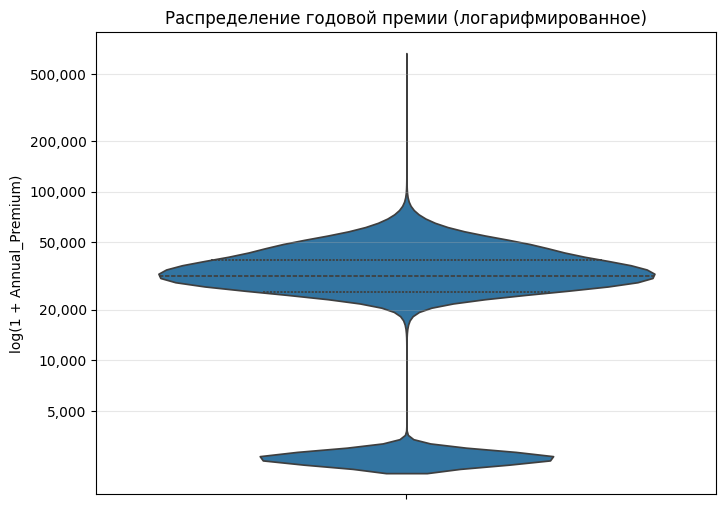

In [29]:
sample = df.sample(n=100_000, random_state=42)

plt.figure(figsize=(8, 6))
sns.violinplot(
    y=np.log1p(sample['Annual_Premium']),
    inner='quartile'
)

plt.title('Распределение годовой премии (логарифмированное)')
plt.ylabel('log(1 + Annual_Premium)')

yticks_original = [5_000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000]
yticks_original = [x for x in yticks_original
                   if sample['Annual_Premium'].min() <= x <= sample['Annual_Premium'].max()]
yticks_log = np.log1p(yticks_original)

plt.yticks(yticks_log, [f'{x:,}' for x in yticks_original])
plt.grid(axis='y', alpha=0.3)
plt.show()

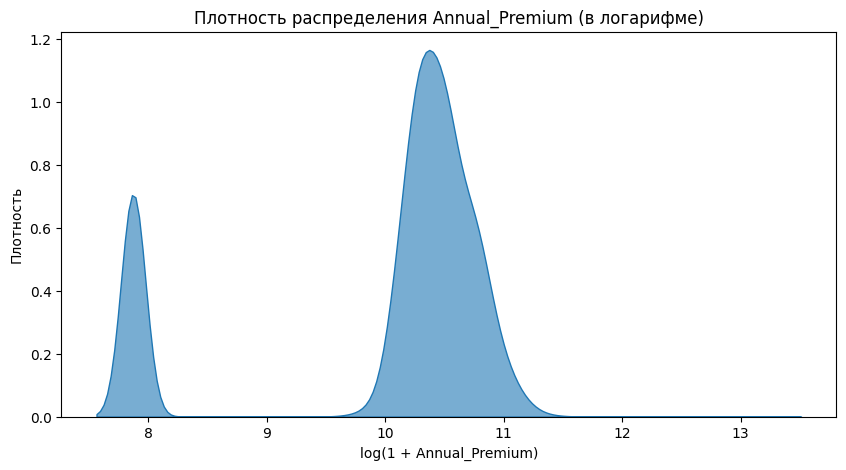

In [30]:
plt.figure(figsize=(10, 5))
sns.kdeplot(np.log1p(sample['Annual_Premium']), fill=True, alpha=0.6)
plt.title('Плотность распределения Annual_Premium (в логарифме)')
plt.xlabel('log(1 + Annual_Premium)')
plt.ylabel('Плотность')
plt.show()

**Вывод по распределению "Annual_Premium":**
- Распределение сильно скошено вправо
- Необходимо логарифмирование для превращения мультипликативного отношения в аддитивное

In [31]:
df['Log_Annual_Premium'] = np.log1p(df['Annual_Premium'])

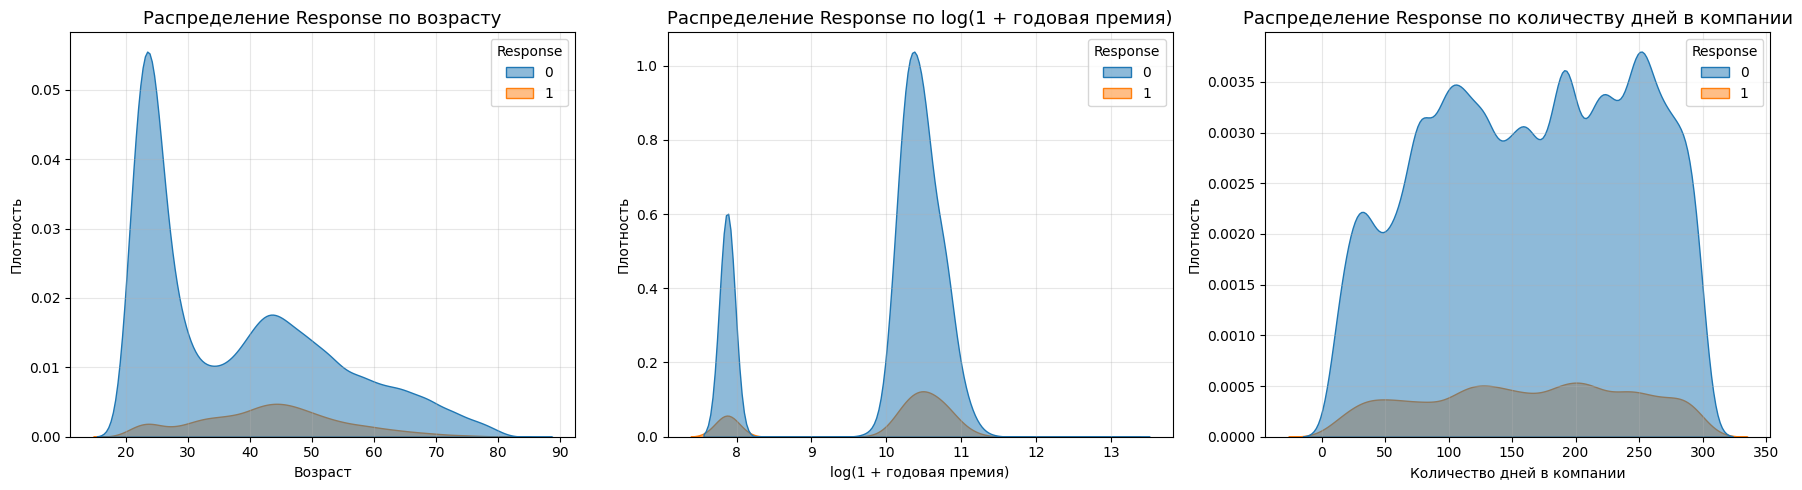

In [32]:
sample = df.sample(n=100_000, random_state=42)

sample['Log_Annual_Premium'] = np.log1p(sample['Annual_Premium'])

num_features = ['Age', 'Log_Annual_Premium', 'Vintage']
titles = ['возрасту', 'log(1 + годовая премия)', 'количеству дней в компании']
feature_labels = ['Возраст', 'log(1 + годовая премия)', 'Количество дней в компании']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_features):
    sns.kdeplot(
        data=sample,
        x=col,
        hue='Response',
        ax=axes[i],
        fill=True,
        alpha=0.5,
        palette=['#1f77b4', '#ff7f0e']
    )
    axes[i].set_title(f'Распределение Response по {titles[i]}', fontsize=13)
    axes[i].set_xlabel(feature_labels[i])
    axes[i].set_ylabel('Плотность')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Выводы:**

1. Распределение по возрасту:
- молодые клиенты (до 30) реже покупают допстраховку
- клиенты 40–50 лет чаще покупают доп страховку

2. Распределение по log(1 + годовая премия):
- клиенты, которые чаще покупают доп страховку, платят больше
- чем дороже полис - тем выше вероятность согласия

3. Распределение по количеству дней в компании:
- "устоявшиеся" клиенты чаще покупают доп страховку

<a id="fifth"></a>
## Корреляционный анализ по числовым признакам

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


interval columns not set, guessing: ['Age', 'Annual_Premium', 'Vintage', 'Response', 'Region_Code_Percentage', 'Policy_Sales_Channel_Percentage', 'Log_Annual_Premium']


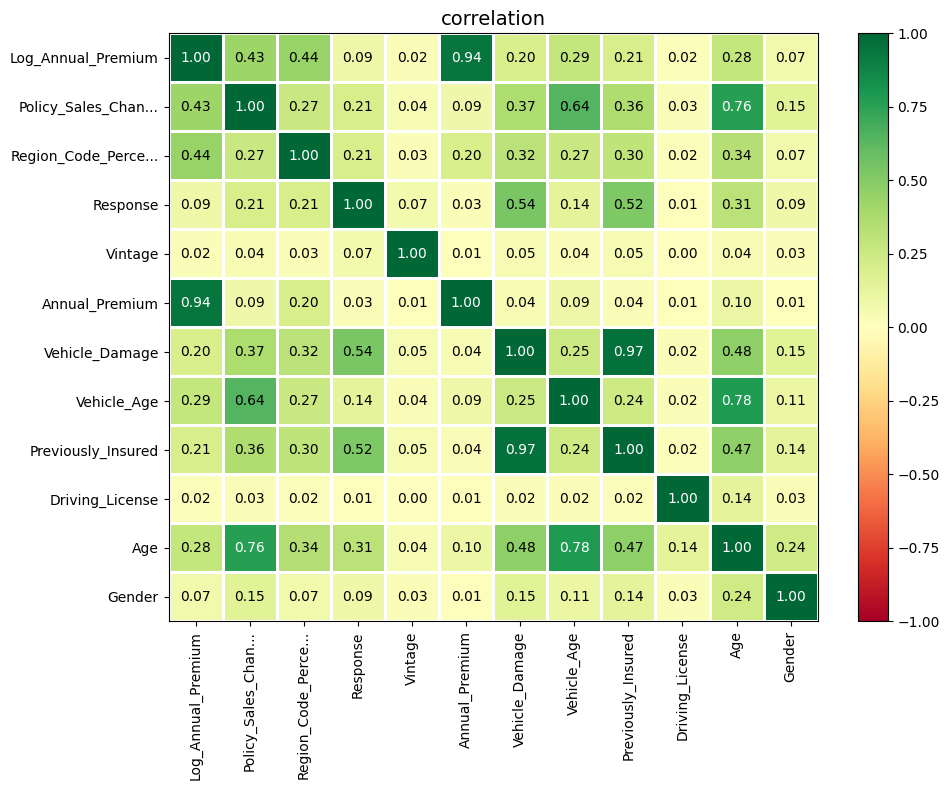

In [33]:
%pip install phik

import phik
from phik.report import plot_correlation_matrix
corr_matrix = df.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(10, 8))

**Вывод:**
- Корреляция "Response" и "Vehicle_Damage" +0.54                  - сильный признак (клиенты с ДТП значительно чаще покупают доп страховку)
- Корреляция "Response" и "Previously_Insured" +0.52              - сильный признак (не застрахованные ранее - основная целевая аудитория)
- Корреляция "Response" и "Age" +0.31                             - умеренный признак (старшие клиенты чаще соглашаются на доп страховку)
- Корреляция "Response" и "Region_Code_Percentage" +0.21          - умеренный признак (клиенты из популярных регионов чаще соглашаются на доп страховку)
- Корреляция "Response" и "Policy_Sales_Channel_Percentage" +0.21 - умеренный признак (клиенты из популярных каналов продаж чаще соглашаются на доп страховку)
- Корреляция "Response" и "Vehicle_Age" +0.14                     - слабый признак, но полезный (старые авто - выше вероятность согласия на доп страховку)
- Остальные признаки слабо коррелируют с целевой переменной "Response"

<a id="sixth"></a>
## 6. Итоги EDA и рекомендации

- Сильные предикторы для "Response": "Vehicle_Damage", "Previously_Insured"
- Умеренные предикторы для "Response": "Age", "Region_Code_Percentage", "Policy_Sales_Channel_Percentage"
- Слабый, но полезный предиктор для "Response": "Vehicle_Age", "Driving_License"

<a id="seventh"></a>
## 7. Baseline - логистическая регрессия

**Обоснования выбора логистической регрессии:**
1. Простота и интерпретируемость - коэффициенты показывают, как каждый признак влияет на вероятность.
2. Быстрое обучение и предсказание - обучение за секунды и позволяет быстро проверять гипотезы.
3. Хороший ориентир для качества - если сложная модель не превосходит логистическую регрессию, то возможно проблема в данных, а не в модели.
4. Чувствительность к качеству признаков - хорошего результата - качественная подготовка признаков.

**Этапы развития модели:**
1. Baseline - логистическая регрессия: понять, насколько предсказуема задачаи и проверка признаков.
2. Продвинутый baseline - логистическая регрессия и регуляризация: борьба с мультиколлинеарностью.
3. Основная модель - CatBoost: максимальная точность, обрабатка категориальные признаков, устойчива к выбросам и не требует масштабирования.

**Валидация:**
- Проведем кросс-валидацию.
- Применим стратифицированное разделение, так как 85% клиентов отвечают «Нет», 15% — «Да», что является дисбалансом. Такое разделение гарантирует, что доля каждого класса в train и test будет такой же, как в исходном датасете.

<a id="fource"></a>
## Обучение модели

In [34]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [36]:
df = pd.read_csv(FILE_PATH, index_col='id')

<a id="fource"></a>
### Разделение на признаки и целевую переменную

In [37]:
X = df.drop("Response", axis=1)
y = df["Response"]

<a id="fource"></a>
### Предобработка признаков

В данных есть категориальные признаки, которые требуют преобразований.

Для каждого из них применим подходящую предобработку:
- для признаков с высокой кардинальностью: Region_Code и Policy_Sales_Channel - TargetEncoder (риски переобучения будем снижать кросс-валидацией)
- для бинарных признаков: Gender и Vehicle_Damage - OneHotEncoder
- для признака Vehicle_Age для которого порядок имеет смысл - OrdinalEncoder в следующем порядке: ['< 1 Year', '1-2 Year', '> 2 Years']

In [38]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

high_card_encoder = TargetEncoder(cols=high_card_cols)
bool_encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
ord_encoder = OrdinalEncoder(categories = [['< 1 Year', '1-2 Year', '> 2 Years']], dtype=int)

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", high_card_encoder, high_card_cols),
        ("bool", bool_encoder, bool_cols),
        ("ord", ord_encoder, ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [40]:
transformed_X = preprocessor.fit_transform(X, y)

### Разделение выборок

Используем параметр train_size=1000000, чтобы выборка для обучения не занимала слишком много времени и stratify, чтобы сбалансировать выборки по таргету

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, train_size=1000000, stratify=y, random_state=42
)
print("Тренировочная выборка:\n", y_train.value_counts(normalize=True), sep="")
print("Тестовая выборка:\n", y_test.value_counts(normalize=True), sep="")

Тренировочная выборка:
Response
0   0.88
1   0.12
Name: proportion, dtype: float64
Тестовая выборка:
Response
0   0.88
1   0.12
Name: proportion, dtype: float64


### Baseline model - Логистическая регрессия

In [48]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', n_jobs=-1),
)

param_grid = {
    'logisticregression__l1_ratio': np.linspace(0, 1, 10),
    'logisticregression__C': np.linspace(0.1, 100, 10)
}

gs = GridSearchCV(log_reg_pipeline, param_grid=param_grid, cv=skf, scoring="precision", n_jobs=-1)


gs.fit(X_train, y_train)
print(f"Лучшие параметры: {gs.best_params_}")
print(f"Лучшее качество на кросс-валидации: {gs.best_score_}")

ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\Python\Lib\site-packages\sklearn\pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "d:\Python\Lib\site-packages\sklearn\pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "d:\Python\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\sklearn\pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "d:\Python\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "d:\Python\Lib\site-packages\sklearn\base.py", line 897, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\sklearn\preprocessing\_data.py", line 907, in fit
    return self.partial_fit(X, y, sample_weight)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\Python\Lib\site-packages\sklearn\preprocessing\_data.py", line 943, in partial_fit
    X = validate_data(
        self,
    ...<4 lines>...
        reset=first_call,
    )
  File "d:\Python\Lib\site-packages\sklearn\utils\validation.py", line 2954, in validate_data
    out = check_array(X, input_name="X", **check_params)
  File "d:\Python\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "d:\Python\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "d:\Python\Lib\site-packages\pandas\core\generic.py", line 2171, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Female'


              precision    recall  f1-score   support

           0       0.88      1.00      0.93    877003
           1       0.35      0.01      0.02    122997

    accuracy                           0.88   1000000
   macro avg       0.62      0.50      0.48   1000000
weighted avg       0.81      0.88      0.82   1000000



<Axes: >

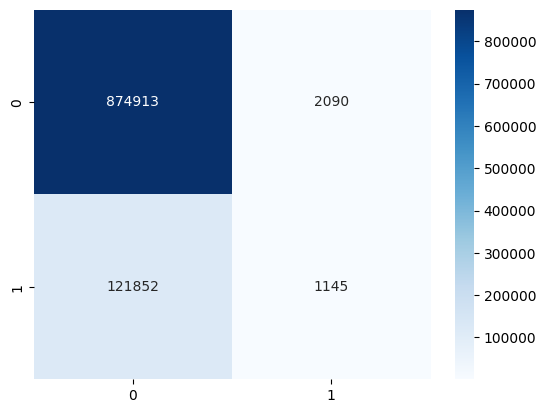

In [ ]:
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

report = classification_report(y_train, y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

Вывод: Надо поработать над признаками, удалить неважные и/или применить другие техники кодирования категориальных признаков, поискать еще другие параметры для логистической регрессии, либо использовать вообще другую модель

### Модель дерева решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
dtc = DecisionTreeClassifier(random_state=42)

tree_param_grid = {
    'max_depth': range(2, 11),
    'min_samples_leaf':  range(1, 6),
    'class_weight': [None, 'balanced']
}

tree_gs = GridSearchCV(dtc, param_grid=tree_param_grid, cv=skf, scoring="precision", n_jobs=-1)


tree_gs.fit(X_train, y_train)
print(f"Лучшие параметры: {tree_gs.best_params_}")
print(f"Лучшее качество на кросс-валидации: {tree_gs.best_score_}")

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1}
Лучшее качество на кросс-валидации: 0.2946328061315954


              precision    recall  f1-score   support

           0       0.98      0.70      0.82    877003
           1       0.29      0.88      0.44    122997

    accuracy                           0.73   1000000
   macro avg       0.64      0.79      0.63   1000000
weighted avg       0.89      0.73      0.77   1000000



<Axes: >

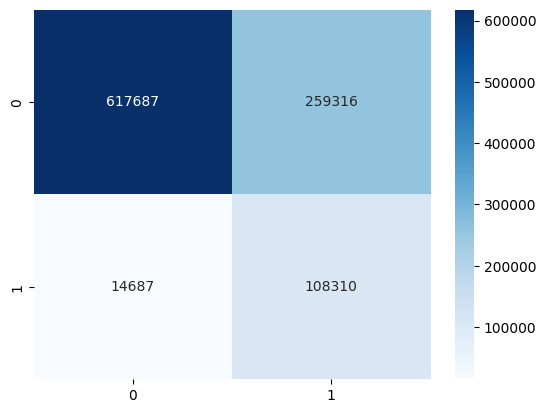

In [ ]:
tree_y_pred = cross_val_predict(tree_gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

report = classification_report(y_train, tree_y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, tree_y_pred), annot=True, fmt='d', cmap='Blues')

Дальнейшие шаги:
- Пересмотреть EDA.
- Выбрать и обосновать выбор метрик качества (Precision, Recall, F1-score, ROC-AUC)
- Fine-tuning логистической регрессии и дерева решений (применить другие техники подбора гиперпараметров, например optuna)
- Модели (Logistic Regression, дерево решений, Random Forest, метод опорных векторов, CatBoost)
- Сравнить метрики применения разных моделей + скорость обученияна на всех данных
- Применить техники оптимизации для работы с большим датасетом
- Уровнять значения целевой переменной с помощью удаления части строк

# Анализ с Random Forest

## Импорты

In [42]:
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

## Кастомный трансформер для частотного кодирования

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.freq_maps[col])
            X_copy[col] = X_copy[col].fillna(self.freq_maps[col].mean())
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if self.cols is None:
            raise ValueError("Колонки не определены. Сначала вызовите fit().")
        return np.array(self.cols)

## 1. Подготовка данных для Random Forest

In [44]:
print("\n1. Подготовка данных для Random Forest...")

df_sample = df.sample(n=1500000, random_state=42)

# Разделяем признаки и целевую переменную
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")



1. Подготовка данных для Random Forest...
Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train: Response
0   0.88
1   0.12
Name: proportion, dtype: float64


## 2. Преобработка признаков

In [45]:
# Определение типов колонок
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", FrequencyEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Обучение препроцессора
preprocessor.fit(X_train)

# Преобразование данных
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

print(f"После трансформации - Train shape: {X_train_transformed.shape}")
print(f"После трансформации - Test shape: {X_test_transformed.shape}")

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

print("Данные готовы!")

После трансформации - Train shape: (1000000, 10)
После трансформации - Test shape: (500000, 10)
Данные готовы!


## 3. Baseline модели для сравнения

In [46]:
# Logistic Regression
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced'
)
log_reg.fit(X_train_scaled, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=5
)
dt_model.fit(X_train_scaled, y_train)

NameError: name 'DecisionTreeClassifier' is not defined

## 4. Базовая модель Random Forest

In [ ]:
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1
)

rf_base.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf_base.predict(X_test_scaled)
y_pred_proba_rf = rf_base.predict_proba(X_test_scaled)[:, 1]

print("\n=== Random Forest (Base) ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_base.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 важных признаков:")
print(feature_importance.head(10))

## 5. Оптимизация с Optuna

In [ ]:
# Функция для Optuna
def objective_all_data(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', {0: 1, 1: 5}])
    }

    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    
    from sklearn.model_selection import cross_val_score
    score = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=2,
        scoring='roc_auc',
        n_jobs=1
    )
    return score.mean()

# Создаем study
study_all_data = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

# Запускаем оптимизацию
start_time = time.time()
study_all_data.optimize(objective_all_data, n_trials=12, show_progress_bar=True)
elapsed_time = time.time() - start_time

print(f"\nOptuna завершена за {elapsed_time/60:.1f} минут")
print(f"Лучший ROC-AUC: {study_all_data.best_value:.4f}")
print(f"Лучшие параметры: {study_all_data.best_params}")

## 6. Финальная модель с оптимизированными параметрами

In [ ]:
rf_optuna_final = RandomForestClassifier(
    n_estimators=176,
    max_depth=11,
    min_samples_split=2,
    min_samples_leaf=3,
    max_features='sqrt',
    bootstrap=True,
    class_weight={0: 1, 1: 6},
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_optuna_final.fit(X_train_scaled, y_train)

# Предсказания
y_pred_optuna = rf_optuna_final.predict(X_test_scaled)
y_pred_proba_optuna = rf_optuna_final.predict_proba(X_test_scaled)[:, 1]

# Оценка
print(f"\n=== Random Forest (Optuna Optimized) ===")
print(f"ROC-AUC на тесте: {roc_auc_score(y_test, y_pred_proba_optuna):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optuna):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optuna):.4f}")
print(f"F1: {f1_score(y_test, y_pred_optuna):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optuna))

## 7. Сравнение моделей

In [ ]:
# Создаем таблицу сравнения
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest (Base)', 'Random Forest (Optuna)'],
    'ROC-AUC': [
        roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, dt_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_optuna)
    ],
    'Precision': [
        precision_score(y_test, log_reg.predict(X_test_scaled)),
        precision_score(y_test, dt_model.predict(X_test_scaled)),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_optuna)
    ],
    'Recall': [
        recall_score(y_test, log_reg.predict(X_test_scaled)),
        recall_score(y_test, dt_model.predict(X_test_scaled)),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_optuna)
    ],
    'F1-Score': [
        f1_score(y_test, log_reg.predict(X_test_scaled)),
        f1_score(y_test, dt_model.predict(X_test_scaled)),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_optuna)
    ]
})

print("\n📊 ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ:")
print("-" * 70)
print(models_comparison.to_string(index=False))
print("-" * 70)

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'orange', 'red']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]
    bars = ax.bar(models_comparison['Model'], models_comparison[metric], color=color, alpha=0.7)
    ax.set_title(f'{metric} по моделям')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Выводы

In [ ]:
print("\n" + "="*60)
print("БИЗНЕС-АНАЛИЗ НА ОСНОВЕ ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

print("\n КЛЮЧЕВЫЕ ВЫВОДЫ:")
print("1. Random Forest с оптимизацией Optuna показывает лучший ROC-AUC")
print("2. Наиболее важные признаки для предсказания:")
for i, (feature, importance) in enumerate(feature_importance.head(5).values, 1):
    print(f"   {i}. {feature}: {importance:.4f}")

print("\n РЕКОМЕНДАЦИИ:")
print("• Vehicle_Damage (ДТП) - самый важный фактор, фокусироваться на клиентах с историей ДТП")
print("• Previously_Insured - новые клиенты более восприимчивы к доп. страховке")
print("• Age - клиенты 40-50 лет чаще соглашаются на доп. страховку")
print("• Vintage - устоявшиеся клиенты компании более лояльны")

print("\n ЦЕЛЕВАЯ АУДИТОРИЯ:")
print("• Новые клиенты (без предыдущей страховки)")
print("• Клиенты с историей ДТП")
print("• Возрастная группа 40-50 лет")
print("• Дорогие страховые полисы")

print("\n" + "="*60)
print("АНАЛИЗ ЗАВЕРШЕН")
print("="*60)
